In [1]:
# IMPORTS
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.ndimage import convolve
import cv2
import nibabel as nib
from sklearn.cluster import KMeans, DBSCAN

Ici, nous traitons les dicoms relatifs à un cancer du pancréas et nous les transformons en numpy arrays. Nous pouvons remarqué que nous traitons des images de taille 260x320 encodée avec 345 valeurs.

In [2]:
ds = pydicom.read_file("data/IM-0001-0001-0001.dcm")
arr = ds.pixel_array

Pour la semaine S5, nous avons décidé de faire du traitement d'image en condisérant les histogrammes relatifs à ces images. Pour ce faire, nous avons implémenté différentes fonctions:    
    *  histogram(arr): retourne l'histogramme d'une image  
    *  Transformation(image, transform): retourne un nouvel array où la valeur des pixels a été transformée  
    *  crimping(arr): retourne un nouvel array dont les valeurs des pixels sont encodées sur 8 bits  
    *  equalize(arr): retourne un nouvel array dont l'histogramme est égalisé  
    *  cumulative(arr): retourne l'histogramme cumulé d'une image  
Toutes les fonctions semblent être en O(n^2)

In [3]:
# Plot histogram of the image above
def histogram(arr):
    maxValue = np.max(arr)
    h,w = arr.shape
    n = h*w
    histogram = np.array([0]*(maxValue+1))
    for i in arr:
        for j in i:
            histogram[j] += 1
    histogram_n = histogram/n#histogramme normalisé --> plus visible
    return histogram_n

def Transformation(image, transform):
    # This function is transforming an image with the Transform vector
    newArr = copy.deepcopy(image)
    for i in range(len(image)):
        for j in range(len(image[i])):
            newArr[i, j] = transform[image[i, j]]
    return newArr  

# Transformation or crimping procedure
def crimping(arr):
    maxValue = np.max(arr)
    histo = histogram(arr)
    Transform = np.arange(0,  maxValue + 1) # This will be the transformation vector
    deltaA = (maxValue - np.min(np.where(histo > 0)))/(255)
    Transform = np.ceil(Transform / deltaA)   
    # Apply the transformation to the original image
    newArr = Transformation(arr, Transform)
    return newArr
    # Plot final figure
    plt.imshow(newArr, cmap='Greys')
    # Plot des histogrammes
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot()

#Egalisation des histogrammes
def equalize(arr):
    h,w = arr.shape
    n = h*w
    C = ((344-1)/n)
    new_arr = np.zeros((h,w),dtype=int)
    histo = histogram(arr)*n
    for i in range(h):
        for j in range(w):
            value = arr[i,j]
            new_arr[i,j] = C*(np.sum(histo[0:value+1]))
    return new_arr

#Histogramme cumulé
def cumulative(arr):
    maxValue = np.max(arr)
    cumul = np.zeros((maxValue))
    histo = histogram(arr)
    for i in range(len(cumul)):
        cumul[i] = np.sum(histo[0:i+1])
    return cumul

Ici, nous appliquons nos différentes fonctions sur les images. Successivement, nous appliquons d'abord la méthode de crimping et ensuite celle qui égalise les histogrammes. Finalement, on calcule l'histogramme cumulé.

Text(0.5, 1.0, "Histogramme cumulé de l'image après égalisation")

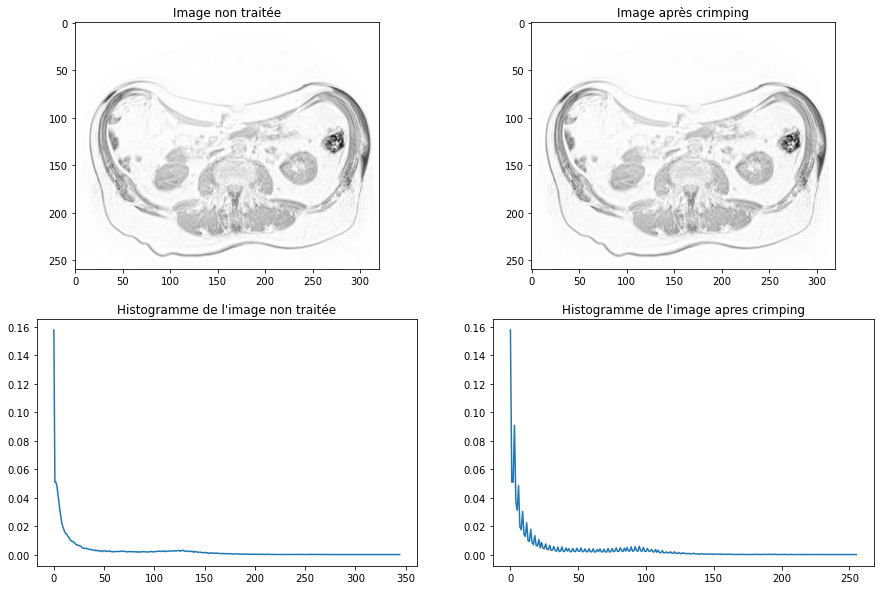

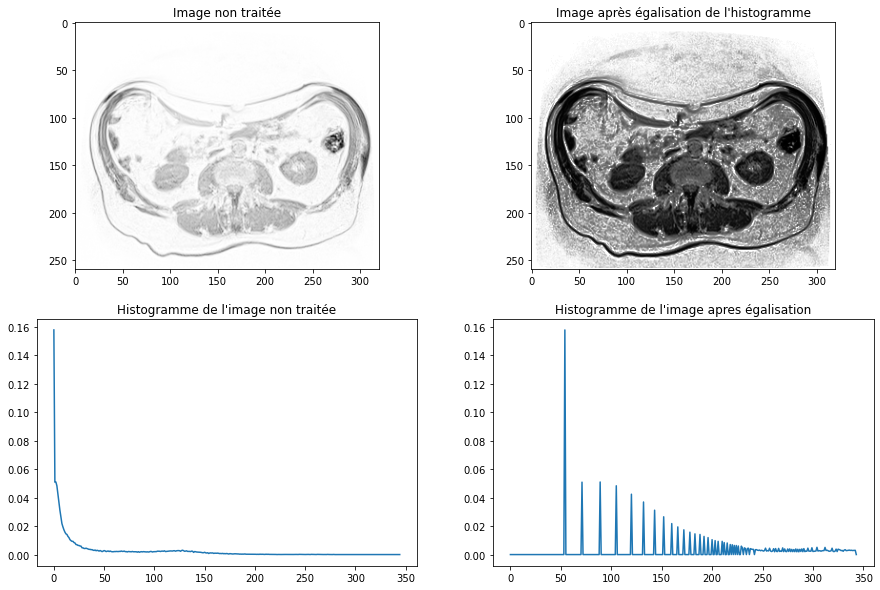

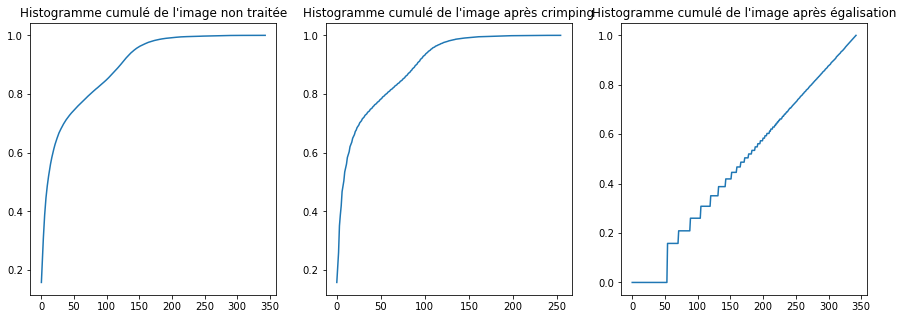

In [4]:
#calcul des variables utiles
arr_crimp = crimping(arr)
histo = histogram(arr)#histogramme de l image non traitee
histogram_lin = histogram(arr_crimp)#histogramme de l image apres crimping

arr_egal = equalize(arr)
histogram_egal = histogram(arr_egal)#histogramme de l image apres égalisation

cumul = cumulative(arr)
cumul_lin = cumulative(arr_crimp)
cumul_egal = cumulative(arr_egal)

#plot des figures relatives au crimping
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(arr_crimp,cmap='Greys')
plt.title('Image après crimping')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l\'image non traitée')

plt.subplot(2,2,4)
plt.plot(histogram_lin)
plt.title('Histogramme de l\'image apres crimping')

#plot des figures relatives à l'égalisation des histogrammes
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(arr_egal,cmap='Greys')
plt.title('Image après égalisation de l\'histogramme')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l\'image non traitée')

plt.subplot(2,2,4)
plt.plot(histogram_egal)
plt.title('Histogramme de l\'image apres égalisation')

#plot des figures relatives aux histogrammes cumulés
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(cumul)
plt.title('Histogramme cumulé de l\'image non traitée')
          
plt.subplot(1,3,2)
plt.plot(cumul_lin)
plt.title('Histogramme cumulé de l\'image après crimping')

plt.subplot(1,3,3)
plt.plot(cumul_egal)
plt.title('Histogramme cumulé de l\'image après égalisation')

Nous pouvons constater que l'application de la méthode crimping ne sert pas à grand chose. 
    C'est peut-être dû au fait que python représente l'image sur 8 bits de toute façon.
Nous pouvons constater que la méthode d'égalisation de l'histogramme fonctionne puisque l'histogramme cumulé tend vers une droite ! On voit que l'on met en évidence les détails mais aussi le bruit.
    On pourrait appliquer un filtrage du type hard thresholding pour supprimer le bruit.  
  
Suite à la réunion de S5, nous avons entendu parler de l'algorithme CLAHE. Celui-ci a été présenté par un autre groupe et donnait de meilleurs résultats qu'une simple égalisation des histogrammes. En effet, cet algorithme consiste à appliquer une égalisation d'histogramme sur des blocs de pixels de taille 8x8 (en général). Il permet donc de ne pas amplifier le bruit. Il nous semblait donc assez prometteur ! Nous avons essayé de l'implémenter nous-mêmes, comme le montre la fonction "Clahe". Cependant, notre algorithme n'est pas du tout optimisé et prend beaucoup de temps supplémentaire par rapport à un algorithme "tout fait" de python. Dès lors, nous avons décidé de continuer à utiliser cet algorithme mais pas comme une boîte noire puisque nous savons ce qu'il réalise. 

In [5]:
#Notre implémentation de CLAHE: pour mémoire
def Clahe(arr):
    h,w = arr.shape
    new_arr = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            C = arr[i:i+7,j:j+7]
            new_C = equalize(C)
            new_arr[i:i+7,j:j+7] = new_C
            if (j+7 >= w):
                break
            else:
                j = j+7
        if(i+7>=h):
            break
        else:
            i = i+7
    plt.imshow(new_arr, cmap='Greys')

#Implémentation de python
def clahe(arr):
    clahe = cv2.createCLAHE()
    cl1 = clahe.apply(arr)
    return cl1

Text(0.5, 1.0, 'Histogramme de l image traitée avec CLAHE')

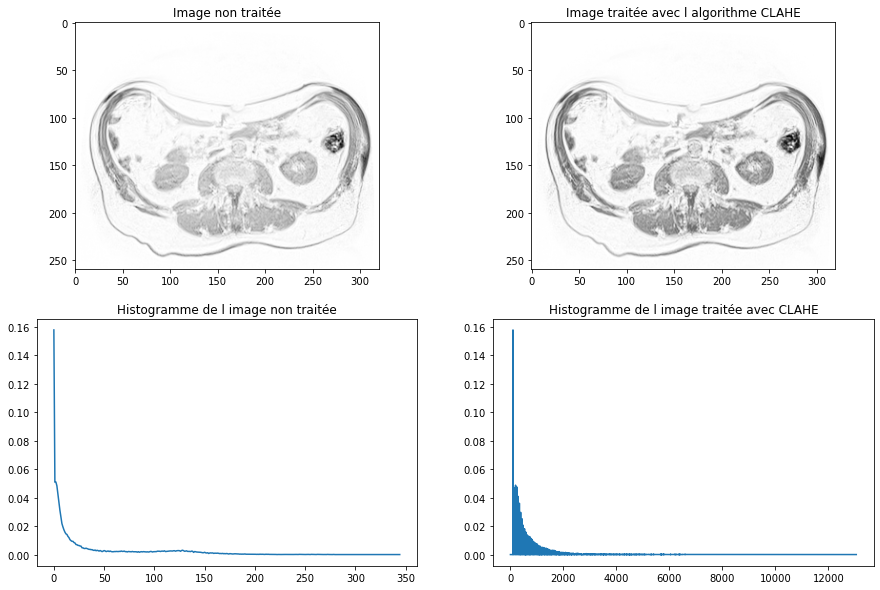

In [6]:
#Plot des résultats avec l'algorithme CLAHE
cl1 = clahe(arr)
histo = histogram(arr)#histogramme de l image non traitee
histo_cl1 = histogram(cl1)#histogramme après CLAHE

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(arr, cmap='Greys')
plt.title('Image non traitée')

plt.subplot(2,2,2)
plt.imshow(cl1, cmap='Greys')
plt.title('Image traitée avec l algorithme CLAHE')

plt.subplot(2,2,3)
plt.plot(histo)
plt.title('Histogramme de l image non traitée')

plt.subplot(2,2,4)
plt.plot(histo_cl1)
plt.title('Histogramme de l image traitée avec CLAHE')

En S5-S6, nous avons décidé d'implémenter l'algorithme k-means qui permet de faire du clustering de l'image. Dans un premier temps, nous travaillons sur des slices 2D mais un futur objectif sera d'utiliser des images 3D. Tout comme pour l'algorithme CLAHE, nous avons essayé d'implémenter nous même cet algorithme. Cependant, n'étant pas assez optimal et prenant énormément de temps pour une slice 2D, nous utiliserons par la suite l'algorithme k-means provenant de la librairie sklearn de Python. Tout comme pour CLAHE, nous laissons pour mémoire notre implémentation de k-means.  
Par ailleurs, nous allons travailler par la suite sur les Nifty et non plus sur les dicoms.

In [6]:
#Ouverture des nifty en tant que numpy array 
img = nib.load('Anonymized - L16223A_port__t1_vibe_dixon_tra_caipi4_bh_320_20161207155610_18.nii')
data = img.get_fdata()#pour avoir un numpy array
#plt.imshow(data[:,:,50], cmap = 'Greys')#plot de la slice 50

#L'implémentation de K-means: pour mémoire
def kmeans(X,K,initype = 'random', maxIter = 100,plotIterations = True):
    """Some example here for good practice"""
    (N,dim) = X.shape
    # Initialization
    
    """ Switch intialization. Don't forget to reset N,X and K by running the upper cell """
    if (initype=='random'):
        centroids = np.random.random((K,dim)) # Random init
    elif (initype=='kmeans_pp'):
        centroids = kmeans_pp_init(X,K) 
    assignments = np.zeros(N)
    iterate = 0
    
    # TO COMPLETE
    convergence = False #pour stopper la boucle, on va regarder si on a convergé ou non
    if plotIterations: #pour le plot a iterate = 0
        plotTheCentroids(X,assignments,centroids,iterate)
    while((iterate <= maxIter) and (convergence == False)):#tant qu'on ne converge pas, on boucle
        iterate +=1   
        # step 1
        for i in range(N):
            distances = np.linalg.norm(centroids-X[i],axis=1)
            assignments[i] = np.argmin(distances)

        previousCentroids = np.copy(centroids)#permet de regarder la convergence des centroides
        # step 2
        for i in range(K):
            cluster = X[assignments == i]
            centroids[i] = np.mean(cluster,axis=0)
        convergence = np.array_equal(previousCentroids,centroids) #on regarde la convergence des centroides pour stopper plus tot
        if plotIterations:
            plotTheCentroids(X,assignments,centroids,iterate)        
            
    return centroids,assignments

#L'implémentation de K-means++: pour mémoire
def kmeans_pp_init(X,K):
    def distance(u,A,j,N):
        D = np.zeros(N)

        for i in range(N):
            distance = u[i] - A[:j]
            D[i] = min(np.linalg.norm(distance, axis = -1))
        return D
    (N,dim) = X.shape
    # Initialization
    centroids = np.zeros((K,dim)) # TO BE MODIFIED
    centroids[0] = X[np.random.randint(0,N)]
    for k in range(1,K):
        D = distance(X,centroids,k,N)
        c = 1/sum(D**2)
        proba = c*(D**2)
        centroids[k] = X[np.random.choice(N,p=proba)]
            
    return centroids


In [7]:
#Fonctions pour transformer les datas mises en input de k-means
def NewListing2D(inputImage, layer):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1], 3))
    for i in range(inputImage.shape[0]):
        for j in range(data.shape[1]):
                X[j + inputImage.shape[1]*i, 0] = i
                X[j + inputImage.shape[1]*i, 1] = j
                X[j + inputImage.shape[1]*i, 2] = inputImage[i, j, layer]
    return X

def NewListing2D2D(inputImage):
    #Function will return a list of X, Y, Z, grayscale number
    X = []
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
            if inputImage[i, j] == 1:
                X.append([i, j])    
    return np.array(X)

def NewListing2Dwo(inputImage, layer):
    #Function will return a list of X, Y, Z, grayscale number
    X = np.zeros((inputImage.shape[0]*inputImage.shape[1], 1))
    for i in range(inputImage.shape[0]):
        for j in range(inputImage.shape[1]):
                #X[j + data.shape[1]*i, 0] = i
                #X[j + data.shape[1]*i, 1] = j
                X[j + inputImage.shape[1]*i, 0] = inputImage[i, j, layer]
    return X

In [8]:
#Cette cellule permet de montrer les résultats via notre implémentation de l'algorithme k-means. 
#Les résultats sont corrects mais cela prend énormément de temps !
"""
K = 50#nombre de clusters
(c,assignments) = kmeans(NewListing2D(data, 42), K, 'kmeans_pp', 100, False)
imageOut = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        imageOut[i, j] = assignments[j + data.shape[1]*i]
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, 42], cmap='Greys')
plt.title("Initial slice")
plt.subplot(1, 2, 2)
plt.imshow(imageOut, cmap='Greys')
plt.title("Our k-means with 50 clusters (x, y, grayscale)")
"""

'\nK = 50#nombre de clusters\n(c,assignments) = kmeans(NewListing2D(data, 42), K, \'kmeans_pp\', 100, False)\nimageOut = np.zeros((data.shape[0], data.shape[1]))\nfor i in range(data.shape[0]):\n    for j in range(data.shape[1]):\n        imageOut[i, j] = assignments[j + data.shape[1]*i]\nplt.figure(figsize=(15,10))\nplt.subplot(1, 2, 1)\nplt.imshow(data[:, :, 42], cmap=\'Greys\')\nplt.title("Initial slice")\nplt.subplot(1, 2, 2)\nplt.imshow(imageOut, cmap=\'Greys\')\nplt.title("Our k-means with 50 clusters (x, y, grayscale)")\n'

En S6-S7, nous avons implémenté du spectral clustering à l'aide des méthodes fournies dans la librairie python sklearn. Concrètement, sur le cluster regroupant le foie et d'autres organes, nous appliquons l'algorithme DBSCAN qui va segmenter en plusieurs zônes le cluster. Ceci se fait en considérant les voisins les plus proches. Par ailleurs, nous utilisons désormais l'implémentation de k-means de la librairie sklearn de Python étant donné qu'elle est beaucoup plus optimale que la notre. Cette semaine, nous travaillerons encore avec des slices 2D. Nous allons montrer nos résultats lorsqu'il y a 3 ou 4 clusters dans une image. Evidemment, l'estimation de ce nombre est essentielle pour avoir une bonne segmentation.

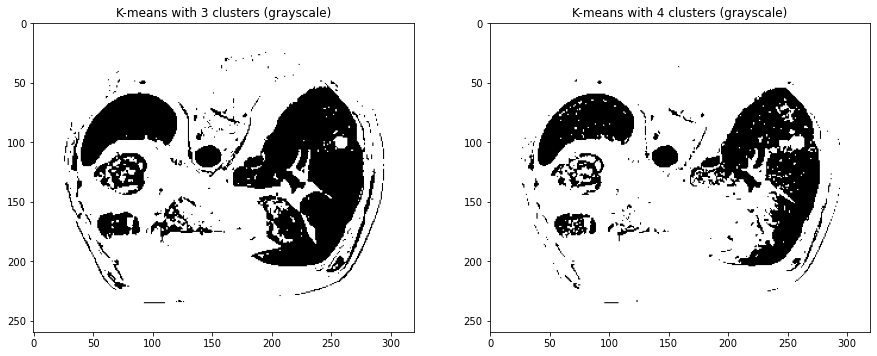

In [9]:
#Segmentation d'une slice en 3 ou 4 clusters
#Utilisation de l'algorithme k-means provenant de la librairie sklearn de Python
x = NewListing2Dwo(data, 42)
kmeans1 = KMeans(n_clusters=3).fit(x)
kmeans2 = KMeans(n_clusters=4).fit(x)
y_kmeans = kmeans1.predict(x)
y_kmeans2 = kmeans2.predict(x)
good_kernel = y_kmeans[100*300+ 250] # TO BE ADAPTED MAYBE
good_kernel2 = y_kmeans2[100*300+ 250] # TO BE ADAPTED MAYBE
y_bw = (y_kmeans == good_kernel)
y_bw2 = (y_kmeans2 == good_kernel2)
imageOut2 = np.zeros((data.shape[0], data.shape[1]))
imageOut22 = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        imageOut2[i, j] = y_bw[j + data.shape[1]*i]
        imageOut22[i, j] = y_bw2[j + data.shape[1]*i]

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(imageOut2.T, cmap='Greys')
plt.title("K-means with 3 clusters (grayscale)")
plt.subplot(1, 2, 2)
plt.imshow(imageOut22.T, cmap='Greys')
plt.title("K-means with 4 clusters (grayscale)")
plt.show()

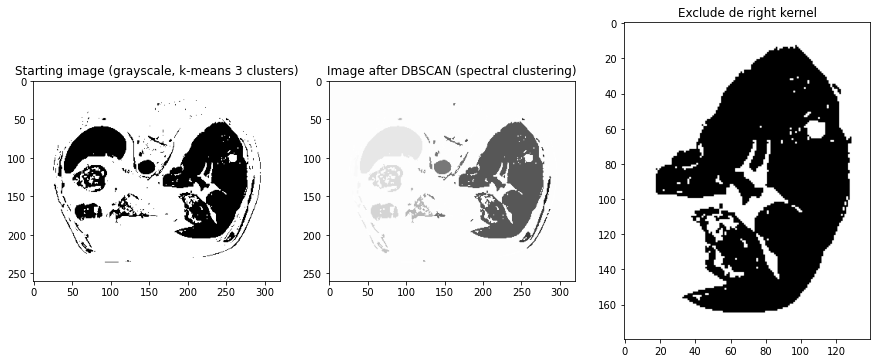

In [11]:
#Spectral clustering via la méthode du DBSCAN
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(imageOut2.T, cmap='Greys')
plt.title("Starting image (grayscale, k-means 3 clusters)")

X = NewListing2D2D(imageOut2)
clustering = DBSCAN(eps=1.5, min_samples=5).fit(X)
y = clustering.labels_
#print(sum(y == -1))
imageOut3 = np.zeros((imageOut2.shape[0], imageOut2.shape[1]))
for i in range(len(y)):
    imageOut3[X[i, 0], X[i, 1]] = y[i]
good_kernel_DBSCAN = imageOut3[260, 135]
plt.subplot(1, 3, 2)
plt.imshow(imageOut3.T, cmap='Greys')
plt.title("Image after DBSCAN (spectral clustering)")
#good_kernel_DBSCAN = y[9000] # TO BE ADAPTED MAYBE

plt.subplot(1, 3, 3)
plt.imshow((imageOut3[150:290,40:220].T == good_kernel_DBSCAN), cmap='Greys')
plt.title("Exclude de right kernel")
plt.show()

En S7-S8, nous appliquons des opérateurs morphologiques afin de surestimer le foie et donc la tumeur. Nous utilisons également plusieurs slices pour faire resortir le foie en 3D.

In [10]:
#Nous traitons plusieurs slices pour pouvoir faire resortir le foie en 3D
#L'execution de cette cellule prend du temps
OutputData = np.zeros(data.shape)
SliceStart = 40
SliceEnd = 50
kmeansSlice = [] # You can recover the K-means of this slice here (labels and so on)
DBSCANSlice = [] # You can recover the DBSCAN of this slice here (labels and so on)
DBSCANgoodkernel = [] # You can recover the kernel of the "foie" with this list after the DBSCAN (not as simple than k-means since not all data is used)
OutputDataKmeans = np.zeros(data.shape)
OutputDataKmeansSelect = np.zeros(data.shape)
for i in range(SliceStart):
    kmeansSlice.append(" ")
    DBSCANSlice.append(" ")
    DBSCANgoodkernel.append(" ")
for sliceNumber in range(SliceStart, SliceEnd):
    # Recover data of the slice
    sliceData = NewListing2Dwo(data, sliceNumber)
    # Apply K-means to the slice
    kmeansSlice.append(KMeans(n_clusters=3).fit(sliceData))
    y_kmeansSlice = kmeansSlice[sliceNumber].labels_
    good_kernelSlice = y_kmeansSlice[100*300+ 250]
    y_bwSlice = (y_kmeansSlice == good_kernelSlice)
    imageOutKmeans = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            imageOutKmeans[i, j] = y_bwSlice[j + data.shape[1]*i]
            OutputDataKmeans[i, j, sliceNumber] = y_kmeansSlice[j + data.shape[1]*i]
            OutputDataKmeansSelect[i, j, sliceNumber] = y_bwSlice[j + data.shape[1]*i]
    #Apply DB-SCAN
    newData2Slice = NewListing2D2D(imageOutKmeans)
    X = newData2Slice
    DBSCANSlice.append(DBSCAN(eps=1.5, min_samples=5).fit(X))
    y = DBSCANSlice[sliceNumber].labels_
    for i in range(len(y)):
        OutputData[newData2Slice[i, 0], newData2Slice[i, 1], sliceNumber] = y[i]
    DBSCANgoodkernel.append(OutputData[260, 135, sliceNumber])

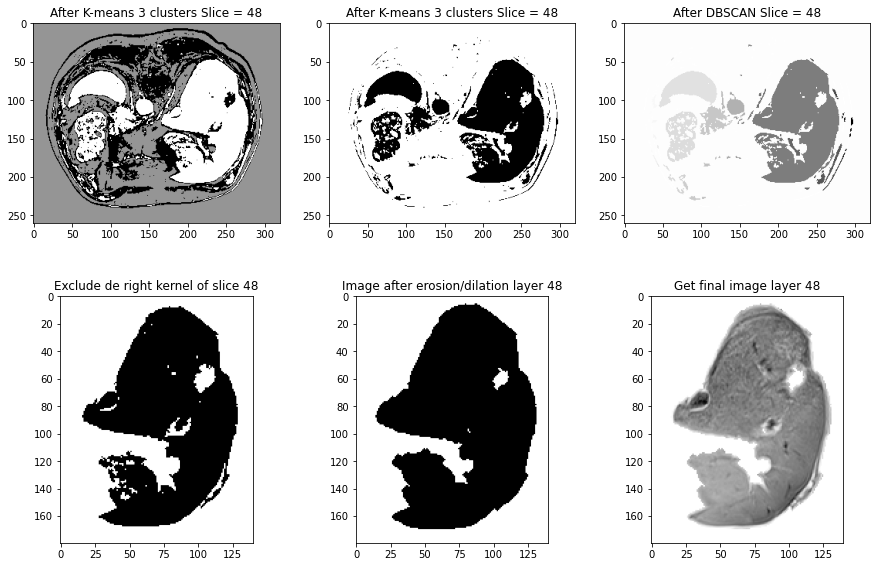

In [11]:
# Plot sliceNum (if it was simulated)
sliceNum = 48
plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.imshow(OutputDataKmeans[:, :, sliceNum].T, cmap='Greys')
plt.title("After K-means 3 clusters Slice = " + str(sliceNum))

plt.subplot(2, 3, 2)
plt.imshow(OutputDataKmeansSelect[:, :, sliceNum].T, cmap='Greys')
plt.title("After K-means 3 clusters Slice = " + str(sliceNum))

plt.subplot(2, 3, 3)
plt.imshow(OutputData[:, :, sliceNum].T, cmap='Greys')
plt.title("After DBSCAN Slice = " + str(sliceNum))

plt.subplot(2, 3, 4)
OutputTest = np.uint8((OutputData[:, :, sliceNum] == DBSCANgoodkernel[sliceNum]))
plt.imshow(OutputTest[150:290,40:220].T, cmap='Greys') #*data[:, :, sliceNum]
plt.title("Exclude de right kernel of slice " + str(sliceNum))

plt.subplot(2, 3, 5)
kernel = np.ones((3,3),np.uint8)
kernel[0, 0] = 0
kernel[2, 0] = 0
kernel[0, 2] = 0
kernel[2, 2] = 0
dilatedImage = cv2.dilate(OutputTest,kernel,iterations = 2)
plt.imshow(dilatedImage[150:290,40:220].T, cmap='Greys') #*data[:, :, sliceNum]
plt.title("Image after erosion/dilation layer " + str(sliceNum))

plt.subplot(2, 3, 6)
plt.imshow((dilatedImage*data[:, :, sliceNum])[150:290,40:220].T, cmap='Greys') #*data[:, :, sliceNum]
plt.title("Get final image layer " + str(sliceNum))
plt.show()

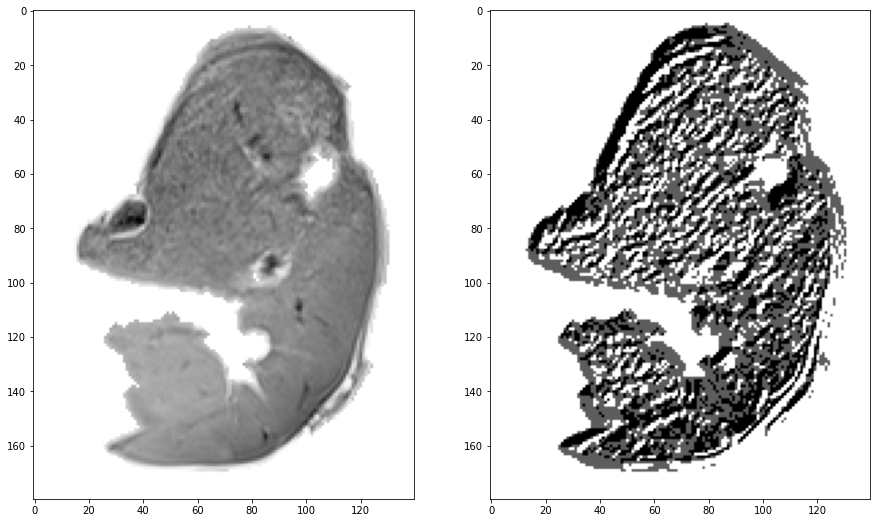

In [12]:
def sobel_operator(A):
    kx = [[0, 0, 0], [-1, 0, 1], [0, 0, 0]]#[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ky = [[0, -1, 0], [0, 0, 0], [0, 1, 0]]#[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
    Gx = convolve(A, kx, mode='constant', cval=0.0)
    Gy = convolve(A, ky, mode='constant', cval=0.0)
    G = Gx + Gy*1j
    return abs(G), np.angle(G)

foieImage = np.array(dilatedImage*data[:, :, sliceNum]).astype(np.uint16)
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(foieImage[150:290,40:220].T, cmap='Greys')
derivFoieImage, _ = sobel_operator(foieImage)
plt.subplot(1, 2, 2)
plt.imshow(derivFoieImage[150:290,40:220].T, cmap='Greys')
# DO Otsu, watershed or region growing

'\n# Iterate through unique labels\ntotal_area = 0\nfor label in np.unique(labels):\n    if label == 0:\n        continue\n\n    # Create a mask\n    mask = np.zeros(image.shape, dtype="uint8")\n    mask[labels == label] = 255\n\n    # Find contours and determine contour area\n    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n    cnts = cnts[0] if len(cnts) == 2 else cnts[1]\n    c = max(cnts, key=cv2.contourArea)\n    area = cv2.contourArea(c)\n    total_area += area\n    cv2.drawContours(image, [c], -1, (36,255,12), 4)\nprint(total_area)\nplt.figure()\ncv2.imshow(\'image\', image)\n'

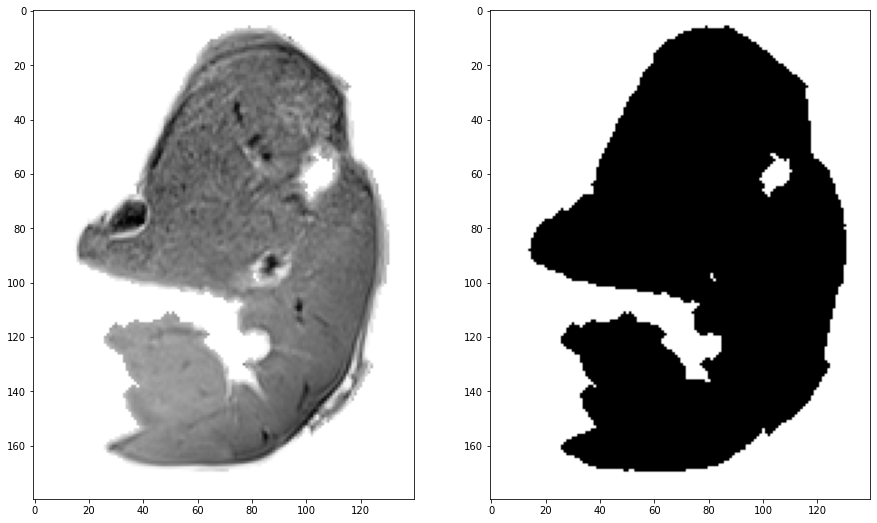

In [13]:
#import numpy as np
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
#import matplotlib.pyplot as plt

image = foieImage#np.logical_or(mask_circle1, mask_circle2)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
from scipy import ndimage
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = morphology.label(local_maxi)
labels = watershed(-distance, markers, mask=image)
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(image[150:290,40:220].T,cmap='Greys')
plt.subplot(1, 2, 2)
plt.imshow(labels[150:290,40:220].T,cmap='Greys')
"""
# Iterate through unique labels
total_area = 0
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(image.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    total_area += area
    cv2.drawContours(image, [c], -1, (36,255,12), 4)
print(total_area)
plt.figure()
cv2.imshow('image', image)
"""


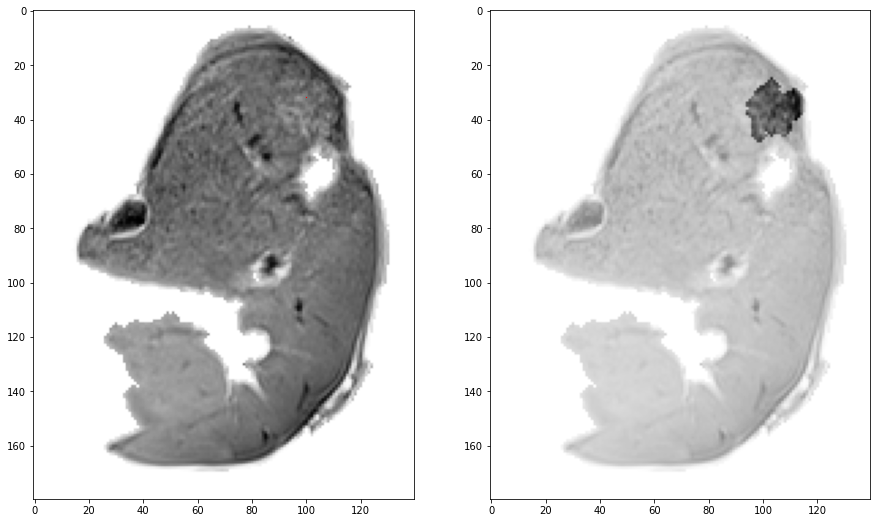

In [16]:
seed = [250, 72]
toDoList = [seed]
done = []
image = foieImage.astype(np.int32)
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(image[150:290,40:220].T,cmap='Greys')
plt.plot(seed[0]-150, seed[1]-40, ',r')
sensitivity = 18
while(len(toDoList) > 0):
    if toDoList[0] in done:
        toDoList.pop(0)
    else:
        tmp = toDoList.pop(0)
        #print(tmp[0])
        #print(abs(image[tmp[0]][tmp[1]] - image[tmp[0] - 1][tmp[1]]))
        done.append(tmp)
        if abs(image[tmp[0]][tmp[1]] - image[tmp[0] - 1][tmp[1]]) < sensitivity:
            toDoList.append([tmp[0] - 1, tmp[1]])
        if abs(image[tmp[0]][tmp[1]] - image[tmp[0] + 1][tmp[1]]) < sensitivity:
            toDoList.append([tmp[0] + 1, tmp[1]])
        if abs(image[tmp[0], tmp[1]] - image[tmp[0], tmp[1] - 1]) < sensitivity:
            toDoList.append([tmp[0], tmp[1] - 1])
        if abs(image[tmp[0]][tmp[1]] - image[tmp[0]][tmp[1] + 1]) < sensitivity:
            toDoList.append([tmp[0], tmp[1] + 1])
done = np.array(done)
newDone = np.zeros(image.shape)
for i in done:
    newDone[i[0], i[1]] = 1
kernel = np.ones((3,3),np.uint8)
kernel[0, 0] = 0
kernel[2, 0] = 0
kernel[0, 2] = 0
kernel[2, 2] = 0
newDone = cv2.dilate(newDone,kernel,iterations = 2)
#print(done[:, 0])
plt.subplot(1, 2, 2)
plt.imshow((newDone*foieImage*1 + foieImage)[150:290,40:220].T,cmap='Greys')
#plt.plot(done[:, 0], done[:, 1], ',r')

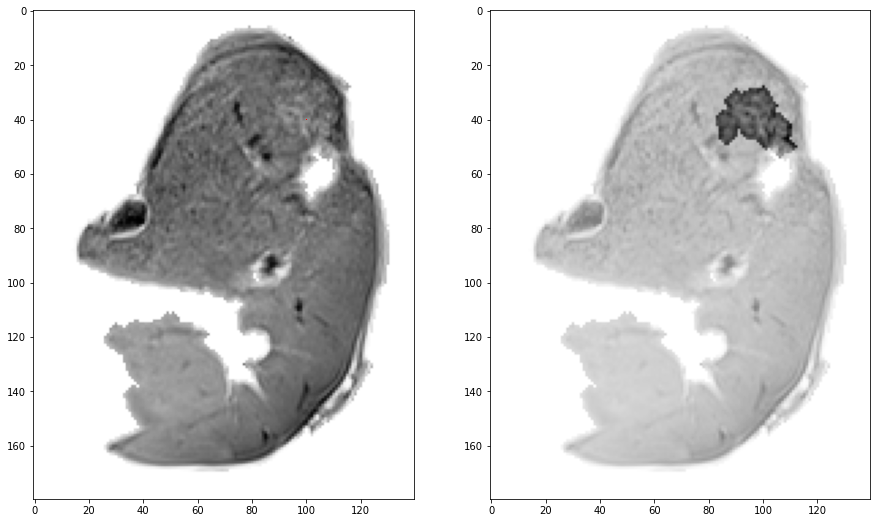

In [14]:
def mean(A):
    if len(A) == 0:
        return 0
    else:
        return sum(A)/len(A)


seed = [250, 80]
toDoList = [seed]
done = []
doneData = []
image = foieImage.astype(np.int32)
kx = [[0, 0, 0, 0, 0], [0, 1, 2, 1, 0], [0, 2, 5, 2, 0], [0, 1, 2, 1, 0], [0, 0, 0, 0, 0]]
#image = convolve(image, kx, mode='constant', cval=0.0)
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(image[150:290,40:220].T,cmap='Greys')
plt.plot(seed[0]-150, seed[1]-40, ',r')
sensitivity = 30
while(len(toDoList) > 0):
    if toDoList[0] in done:
        toDoList.pop(0)
    else:
        tmp = toDoList.pop(0)
        
        #print(tmp[0])
        #print(abs(image[tmp[0]][tmp[1]] - image[tmp[0] - 1][tmp[1]]))
        done.append(tmp)
        doneData.append(image[tmp[0]][tmp[1]])
        if abs(mean(doneData) - image[tmp[0] - 1][tmp[1]]) < sensitivity:
            toDoList.append([tmp[0] - 1, tmp[1]])
        if abs(mean(doneData) - image[tmp[0] + 1][tmp[1]]) < sensitivity:
            toDoList.append([tmp[0] + 1, tmp[1]])
        if abs(mean(doneData) - image[tmp[0], tmp[1] - 1]) < sensitivity:
            toDoList.append([tmp[0], tmp[1] - 1])
        if abs(mean(doneData) - image[tmp[0]][tmp[1] + 1]) < sensitivity:
            toDoList.append([tmp[0], tmp[1] + 1])
done = np.array(done)
newDone = np.zeros(image.shape)
for i in done:
    newDone[i[0], i[1]] = 1
kernel = np.ones((3,3),np.uint8)
kernel[0, 0] = 0
kernel[2, 0] = 0
kernel[0, 2] = 0
kernel[2, 2] = 0
newDone = cv2.dilate(newDone,kernel,iterations = 2)
#print(done[:, 0])
plt.subplot(1, 2, 2)
plt.imshow((newDone*foieImage*1 + foieImage)[150:290,40:220].T,cmap='Greys')
#plt.plot(done[:, 0], done[:, 1], ',r')

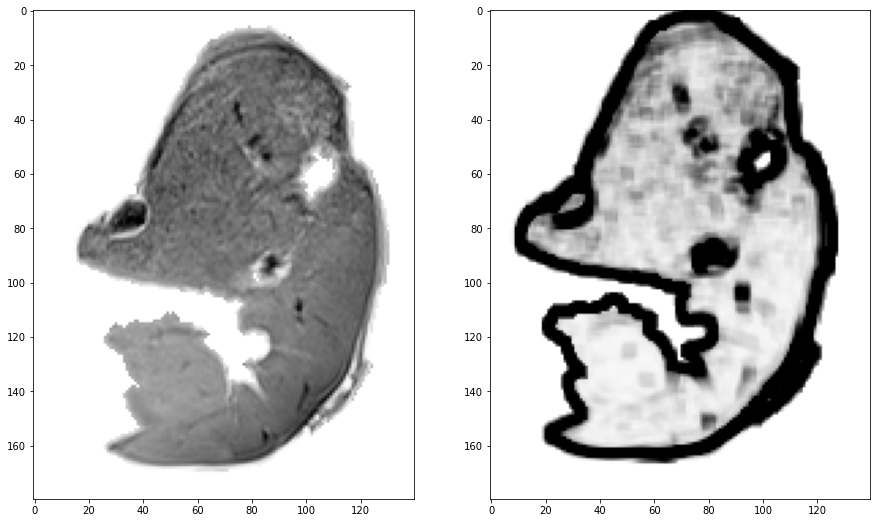

In [17]:
def variancebloc(A):
    varian = []
    sens = 50
    for i in range(5, len(A)-5):
        tmp = []
        for j in range(5, len(A[0]) - 5):
            mean = 0
            for k in range(-2, 3):
                for l in range(-2, 3):
                    mean = mean + A[i + k, j + l]/25
            variantmp = 0
            for k in range(-2, 3):
                for l in range(-2, 3):
                    variantmp = variantmp + (A[i + k, j + l] - mean)**2 / 25
            variantmp = variantmp**(1/2)
            if variantmp > sens:
                 tmp.append(sens)
            else:
                tmp.append(variantmp)
        varian.append(tmp)
    return varian


image = foieImage.astype(np.int32)
#datakk = datakkkkk(image)
imagevar = np.array(variancebloc(image))


plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(image[150:290,40:220].T, cmap='Greys')
#derivFoieImage, _ = sobel_operator(foieImage)
plt.subplot(1, 2, 2)
plt.imshow(imagevar[150:290,40:220].T, cmap='Greys')


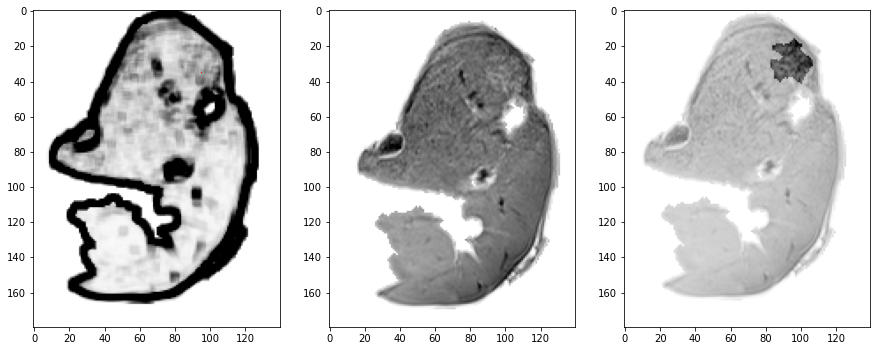

In [18]:
def mean(A):
    if len(A) == 0:
        return 0
    else:
        return sum(A)/len(A)

# region growing in variance
#print(imagevar[250, 80])
seed = [245, 75]
toDoList = [seed]
done = []
doneData = []
image = imagevar.astype(np.int32)
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(image[150:290,40:220].T,cmap='Greys')
plt.plot(seed[0]-150, seed[1]-40, ',r')
plt.subplot(1, 3, 2)
#newimage = np.zeros(image.shape)
#for i in range(len(image)):
#    for j in range(len(image[0])):
#        newimage[i,j] = (20 < image[i, j] < 30)
#plt.imshow(newimage[150:290,40:220].T,cmap='Greys')

plt.imshow(foieImage[150:290,40:220].T,cmap='Greys')

sensitivity = 4
while(len(toDoList) > 0):
    if toDoList[0] in done:
        toDoList.pop(0)
    else:
        tmp = toDoList.pop(0)
        #print(tmp[0])
        #print(abs(image[tmp[0]][tmp[1]] - image[tmp[0] - 1][tmp[1]]))
        done.append(tmp)
        doneData.append(image[tmp[0]][tmp[1]])
        try:
            if abs(mean(doneData) - image[tmp[0] - 1][tmp[1]]) < sensitivity:
                toDoList.append([tmp[0] - 1, tmp[1]])
        except:
            print('error')
        try:
            if abs(mean(doneData) - image[tmp[0] + 1][tmp[1]]) < sensitivity:
                toDoList.append([tmp[0] + 1, tmp[1]])
        except:
            print('error')
        try:
            if abs(mean(doneData) - image[tmp[0], tmp[1] - 1]) < sensitivity:
                toDoList.append([tmp[0], tmp[1] - 1])
        except:
            print('error')
        try:
            if abs(mean(doneData) - image[tmp[0]][tmp[1] + 1]) < sensitivity:
                toDoList.append([tmp[0], tmp[1] + 1])
        except:
            print('error')
done = np.array(done)
newDone = np.zeros(image.shape)
for i in done:
    newDone[i[0], i[1]] = 1
    
kernel = np.ones((3,3),np.uint8)
kernel[0, 0] = 0
kernel[2, 0] = 0
kernel[0, 2] = 0
kernel[2, 2] = 0
newDone = cv2.dilate(newDone,kernel,iterations = 2)
newDone = cv2.erode(newDone,kernel,iterations = 2)
plt.subplot(1, 3, 3)
plt.imshow((newDone*foieImage[5:315, 5:255]*1 + foieImage[5:315, 5:255])[150:290,40:220].T,cmap='Greys')

25.971245638205342


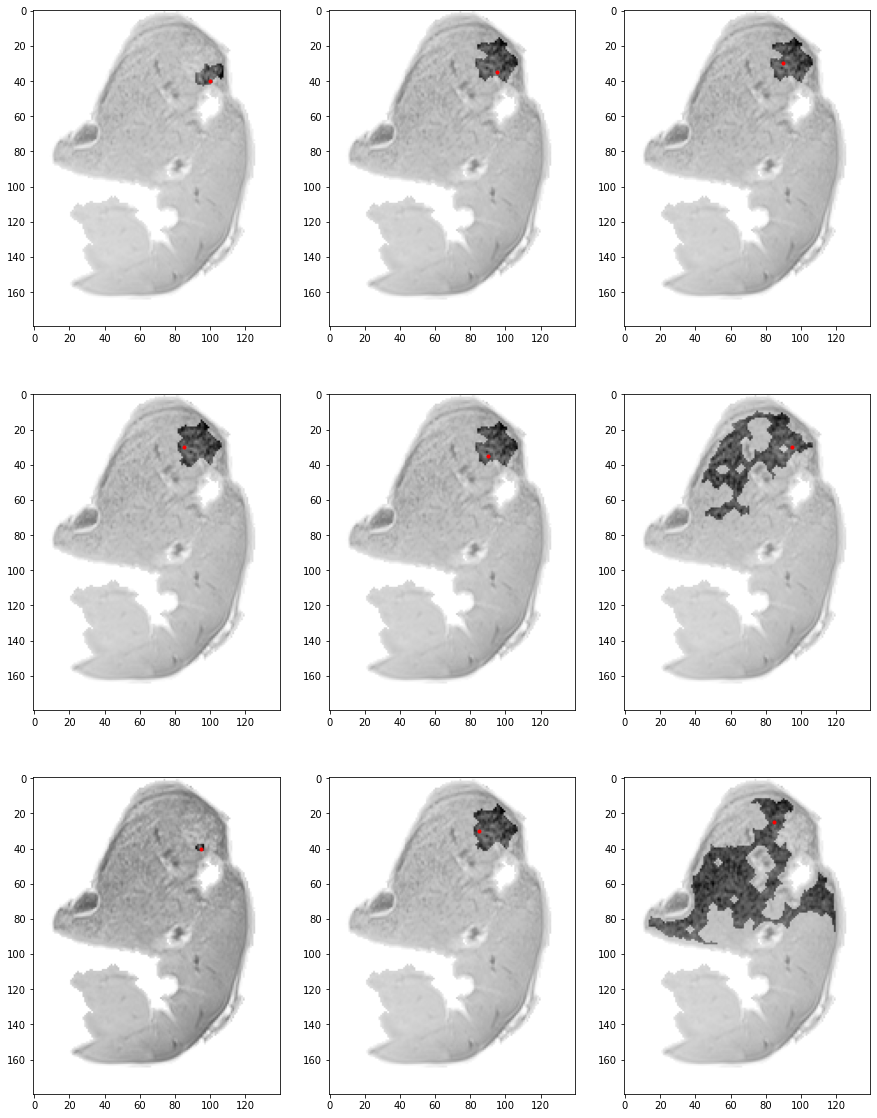

In [19]:
def mean(A):
    if len(A) == 0:
        return 0
    else:
        return sum(A)/len(A)
seeds = [[250, 80], [245, 75], [240, 70], [235, 70], [240, 75], [245, 70], [245, 80], [235, 70], [235, 65]]
# region growing in variance
print(imagevar[250, 80])
plt.figure(figsize=(15,20))
for k in range(9):
    
    toDoList = [seeds[k]]
    done = []
    doneData = []
    image = imagevar.astype(np.int32)

    #newimage = np.zeros(image.shape)
    #for i in range(len(image)):
    #    for j in range(len(image[0])):
    #        newimage[i,j] = (20 < image[i, j] < 30)
    #plt.imshow(newimage[150:290,40:220].T,cmap='Greys')

    #plt.imshow(foieImage[150:290,40:220].T,cmap='Greys')

    sensitivity = 4
    while(len(toDoList) > 0):
        if toDoList[0] in done:
            toDoList.pop(0)
        else:
            tmp = toDoList.pop(0)
            #print(tmp[0])
            #print(abs(image[tmp[0]][tmp[1]] - image[tmp[0] - 1][tmp[1]]))
            done.append(tmp)
            doneData.append(image[tmp[0]][tmp[1]])
            try:
                if abs(mean(doneData) - image[tmp[0] - 1][tmp[1]]) < sensitivity:
                    toDoList.append([tmp[0] - 1, tmp[1]])
            except:
                print('error')
            try:
                if abs(mean(doneData) - image[tmp[0] + 1][tmp[1]]) < sensitivity:
                    toDoList.append([tmp[0] + 1, tmp[1]])
            except:
                print('error')
            try:
                if abs(mean(doneData) - image[tmp[0], tmp[1] - 1]) < sensitivity:
                    toDoList.append([tmp[0], tmp[1] - 1])
            except:
                print('error')
            try:
                if abs(mean(doneData) - image[tmp[0]][tmp[1] + 1]) < sensitivity:
                    toDoList.append([tmp[0], tmp[1] + 1])
            except:
                print('error')
    done = np.array(done)
    newDone = np.zeros(image.shape)
    for i in done:
        newDone[i[0], i[1]] = 1

    kernel = np.ones((3,3),np.uint8)
    kernel[0, 0] = 0
    kernel[2, 0] = 0
    kernel[0, 2] = 0
    kernel[2, 2] = 0
    newDone = cv2.dilate(newDone,kernel,iterations = 2)
    newDone = cv2.erode(newDone,kernel,iterations = 2)
    plt.subplot(3, 3, k+1)
    plt.imshow((newDone*foieImage[5:315, 5:255]*1 + foieImage[5:315, 5:255])[150:290,40:220].T,cmap='Greys')
    plt.plot(seeds[k][0]-150,seeds[k][1]-40, 'r.')


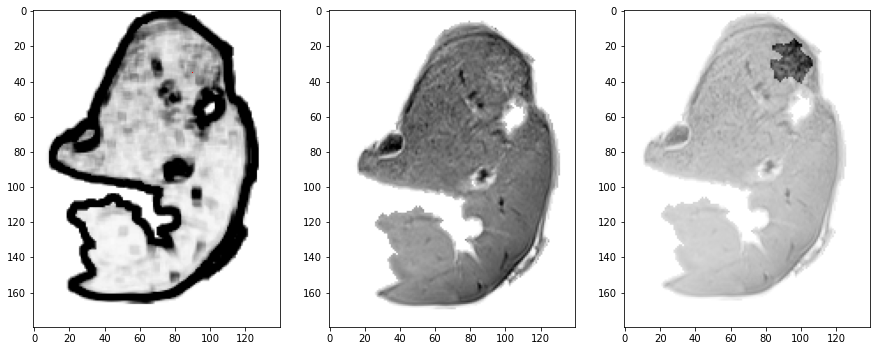

In [26]:
def mean(A):
    if len(A) == 0:
        return 0
    else:
        return sum(A)/len(A)

# region growing in variance
image = imagevar.astype(np.int32)
#print(imagevar[250, 80])
seed = [240, 75]
meanData = 0
sizer = 6
for i in range(-int(sizer/2), int(sizer/2) + 1):
    for j in range(-int(sizer/2), int(sizer/2) + 1):
        meanData += image[seed[0] - i, seed[1] - j]
meanData = meanData / (sizer + 1) / (sizer + 1)
toDoList = [seed]
done = []
doneData = []
image = imagevar.astype(np.int32)
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(image[150:290,40:220].T,cmap='Greys')
plt.plot(seed[0]-150, seed[1]-40, ',r')
plt.subplot(1, 3, 2)
#newimage = np.zeros(image.shape)
#for i in range(len(image)):
#    for j in range(len(image[0])):
#        newimage[i,j] = (20 < image[i, j] < 30)
#plt.imshow(newimage[150:290,40:220].T,cmap='Greys')

plt.imshow(foieImage[150:290,40:220].T,cmap='Greys')

sensitivity = 4
while(len(toDoList) > 0):
    if toDoList[0] in done:
        toDoList.pop(0)
    else:
        tmp = toDoList.pop(0)
        #print(tmp[0])
        #print(abs(image[tmp[0]][tmp[1]] - image[tmp[0] - 1][tmp[1]]))
        done.append(tmp)
        doneData.append(image[tmp[0]][tmp[1]])
        try:
            if abs(meanData - image[tmp[0] - 1][tmp[1]]) < sensitivity:
                toDoList.append([tmp[0] - 1, tmp[1]])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0] + 1][tmp[1]]) < sensitivity:
                toDoList.append([tmp[0] + 1, tmp[1]])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0], tmp[1] - 1]) < sensitivity:
                toDoList.append([tmp[0], tmp[1] - 1])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0]][tmp[1] + 1]) < sensitivity:
                toDoList.append([tmp[0], tmp[1] + 1])
        except:
            print('error')
done = np.array(done)
newDone = np.zeros(image.shape)
for i in done:
    newDone[i[0], i[1]] = 1
    
kernel = np.ones((3,3),np.uint8)
kernel[0, 0] = 0
kernel[2, 0] = 0
kernel[0, 2] = 0
kernel[2, 2] = 0
newDone = cv2.dilate(newDone,kernel,iterations = 2)
newDone = cv2.erode(newDone,kernel,iterations = 2)
plt.subplot(1, 3, 3)
plt.imshow((newDone*foieImage[5:315, 5:255]*1 + foieImage[5:315, 5:255])[150:290,40:220].T,cmap='Greys')

In [116]:
#Create variance bloc from data

seed = [250, 75, 42]

def variancebloc3D(A):
    layerSizeCheck = 10
    checkupSize = 50
    varian = []
    sens = 50
    varian = np.zeros(data.shape)
    print(varian.shape)
    for i in range(seed[0] - checkupSize, seed[0] + checkupSize):
        #tmp = []
        for j in range(seed[1] - checkupSize, seed[1] + checkupSize):
            #tmp2 = []
            for k in range(seed[2] - layerSizeCheck, seed[2] + layerSizeCheck):
                mean = 0
                for l in range(-2, 3):
                    for m in range(-2, 3):
                        for n in range(-2, 3):
                            try:
                                mean = mean + A[i + l, j + m, k + n]/125
                            except:
                                pass
                variantmp = 0
                for l in range(-2, 3):
                    for m in range(-2, 3):
                        for n in range(-2, 3):
                            try:
                                variantmp = variantmp + (A[i + l, j + m, k + n] - mean)**2 / 125
                            except:
                                pass
                variantmp = variantmp**(1/2)
                if variantmp > sens:
                    try:
                        varian[i, j, k] = sens
                    except:
                        pass
                    #tmp2.append(sens)
                else:
                    try:
                        varian[i, j, k] = variantmp
                    except:
                        pass
                    #tmp2.append(variantmp)
            #tmp.append(tmp2)
        #varian.append(tmp)
    return varian


imagevar = variancebloc3D(data)



(320, 260, 112)


In [117]:
#Launch region growing in 3D

image = imagevar.astype(np.int32)
print(image.shape)
sizer = 6
checkupSize = 50
meanData = 0
for i in range(-int(sizer/2), int(sizer/2) + 1):
    for j in range(-int(sizer/2), int(sizer/2) + 1):
        for k in range(-int(sizer/2), int(sizer/2) + 1):
            meanData += image[seed[0] + i, seed[1] + j, seed[2] + k]
meanData = meanData / ((sizer + 1)**3)
toDoList = [seed]
done = []
doneData = []

sensitivity = 5
while(len(toDoList) > 0):
    if toDoList[0] in done:
        toDoList.pop(0)
    else:
        tmp = toDoList.pop(0)
        #print(tmp[0])
        #print(abs(image[tmp[0]][tmp[1]] - image[tmp[0] - 1][tmp[1]]))
        done.append(tmp)
        doneData.append(image[tmp[0], tmp[1], tmp[2]])
        try:
            if abs(meanData - image[tmp[0], tmp[1], tmp[2] + 1]) < sensitivity:
                toDoList.append([tmp[0], tmp[1], tmp[2] + 1])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0], tmp[1], tmp[2] - 1]) < sensitivity:
                toDoList.append([tmp[0], tmp[1], tmp[2] - 1])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0] - 1, tmp[1], tmp[2]]) < sensitivity:
                toDoList.append([tmp[0] - 1, tmp[1], tmp[2]])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0] + 1, tmp[1], tmp[2]]) < sensitivity:
                toDoList.append([tmp[0] + 1, tmp[1], tmp[2]])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0], tmp[1] - 1, tmp[2]]) < sensitivity:
                toDoList.append([tmp[0], tmp[1] - 1, tmp[2]])
        except:
            print('error')
        try:
            if abs(meanData - image[tmp[0], tmp[1] + 1, tmp[2]]) < sensitivity:
                toDoList.append([tmp[0], tmp[1] + 1, tmp[2]])
        except:
            print('error')
done = np.array(done)
newDone = np.zeros(data.shape)
for i in done:
    newDone[i[0], i[1], i[2]] = 1

(320, 260, 112)


In [140]:
print(newDone.shape)
newDoneXY = np.zeros(newDone.shape)
newDoneXZ = np.zeros(newDone.shape)
newDoneYZ = np.zeros(newDone.shape)
#newDone2 = np.zeros(newDone.shape)
kernel = np.ones((3,3),np.uint8)
kernel[0, 0] = 0
kernel[2, 0] = 0
kernel[0, 2] = 0
kernel[2, 2] = 0
print(newDone[:,:,5])

for i in range(30, 50):
    newDoneXY[:,:,i] = cv2.erode(newDone[:,:,i],kernel,iterations = 2)
    newDoneXY[:,:,i] = cv2.dilate(newDoneXY[:,:,i],kernel,iterations = 2)
for i in range(25, 125):
    newDoneXZ[:,i,:] = cv2.erode(newDone[:,i,:],kernel,iterations = 2)
    newDoneXZ[:,i,:] = cv2.dilate(newDoneXZ[:,i,:],kernel,iterations = 2)
for i in range(200, 300):
    newDoneYZ[i,:,:] = cv2.erode(newDone[i,:,:],kernel,iterations = 2)
    newDoneYZ[i,:,:] = cv2.dilate(newDoneYZ[i,:,:],kernel,iterations = 2)
newDone2 = newDoneXY + newDoneXZ + newDoneYZ - newDoneXY*newDoneYZ - newDoneXY*newDoneXZ - newDoneYZ*newDoneXZ + newDoneXY*newDoneXZ*newDoneYZ

(320, 260, 112)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


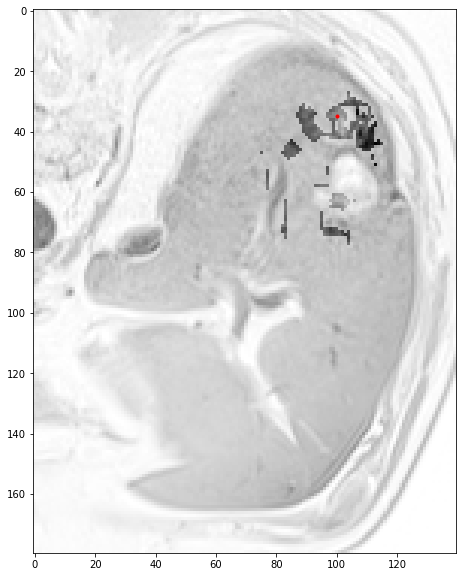

In [146]:
plt.figure(figsize=(15,10))

plt.imshow((newDone2*data + data)[150:290,40:220, 44].T,cmap='Greys')
plt.plot(seed[0]-150, seed[1]-40, 'r.')